# Python implementation of the Max Unmix method
- Originally written in R, Maxbauer, D. P., Feinberg, J. M., & Fox, D. L. (2016). MAX UnMix: A web application for unmixing magnetic coercivity distributions. Computers & Geosciences, 95, 140–145. https://doi.org/10.1016/j.cageo.2016.07.009
- The code below shows our Python implementation of the Max Unmix method, and show a comparison with the lmfit uncertainty estimation.

## Import scientific python libraries

Run the cell below to import the functions needed for the notebook.

In [1]:
import pmagpy.rockmag as rmag

import pmagpy.contribution_builder as cb
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## MaxUnmix example
- MaxUnmix example data file

### import data

In [2]:
MaxUmnix_data = pd.read_csv('../example_data/backfield_unmixing/MaxUnmix_example.csv')
MaxUmnix_data['B'] = -MaxUmnix_data['B']/1000
MaxUmnix_data

,B,M
0,-0.00146,6.950000e-06
1,-0.00224,6.930000e-06
2,-0.00305,6.900000e-06
3,-0.00389,6.860000e-06
4,-0.00477,6.830000e-06
...,...,...
93,-0.84446,3.320000e-07
94,-0.88053,2.450000e-07
95,-0.91852,1.590000e-07
96,-0.95798,7.670000e-08


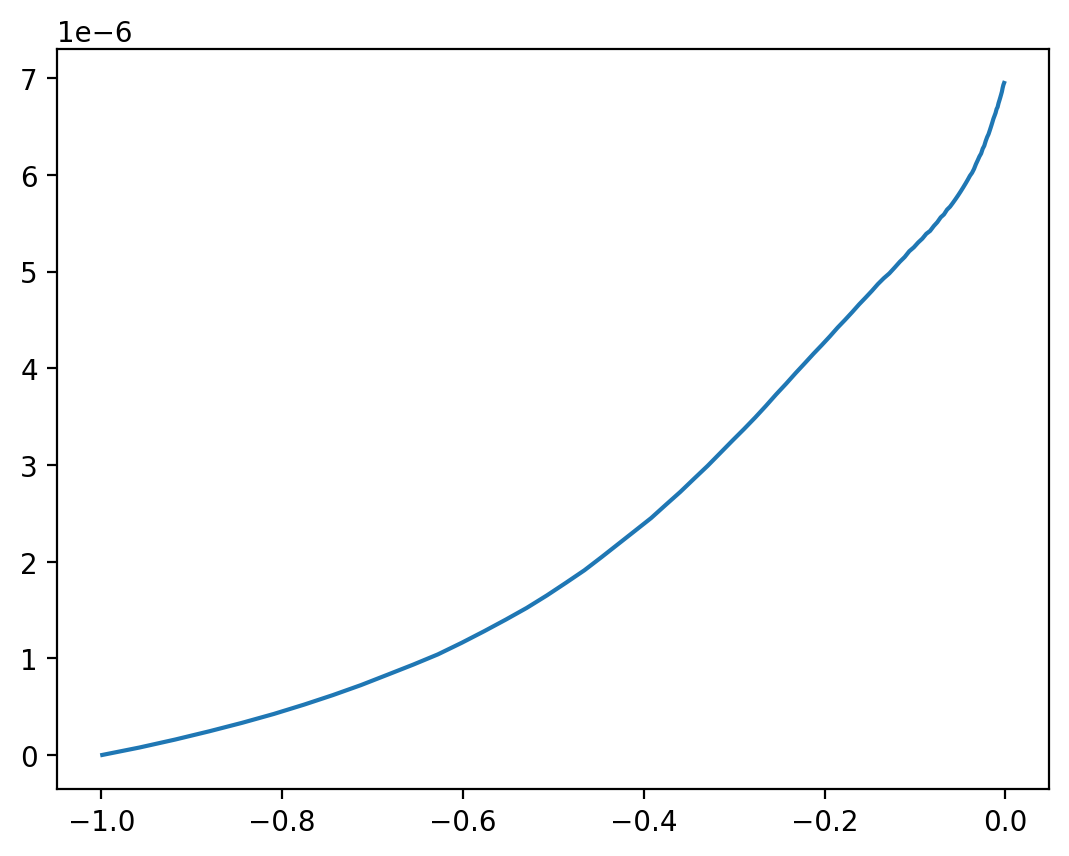

In [3]:
plt.plot(MaxUmnix_data['B'], MaxUmnix_data['M'])

In [4]:
rmag.find_y_crossing(MaxUmnix_data['B'], MaxUmnix_data['M'])

In [9]:
MaxUmnix_experiment, Bcr = rmag.backfield_data_processing(MaxUmnix_data, field='B', magnetization='M', smooth_frac=0.05)


In [10]:
MaxUmnix_experiment

,B,M,magn_mass_shift,log_dc_field,smoothed_magn_mass_shift,smoothed_log_dc_field
0,-0.00146,6.950000e-06,6.950000e-06,0.164353,6.950580e-06,0.164353
1,-0.00224,6.930000e-06,6.930000e-06,0.350248,6.926971e-06,0.350248
2,-0.00305,6.900000e-06,6.900000e-06,0.484300,6.894074e-06,0.484300
3,-0.00389,6.860000e-06,6.860000e-06,0.589950,6.860672e-06,0.589950
4,-0.00477,6.830000e-06,6.830000e-06,0.678518,6.828790e-06,0.678518
...,...,...,...,...,...,...
93,-0.84446,3.320000e-07,3.320000e-07,2.926579,3.329773e-07,2.926579
94,-0.88053,2.450000e-07,2.450000e-07,2.944744,2.455264e-07,2.944744
95,-0.91852,1.590000e-07,1.590000e-07,2.963089,1.599512e-07,2.963089
96,-0.95798,7.670000e-08,7.670000e-08,2.981356,7.825401e-08,2.981356


## backfield processing

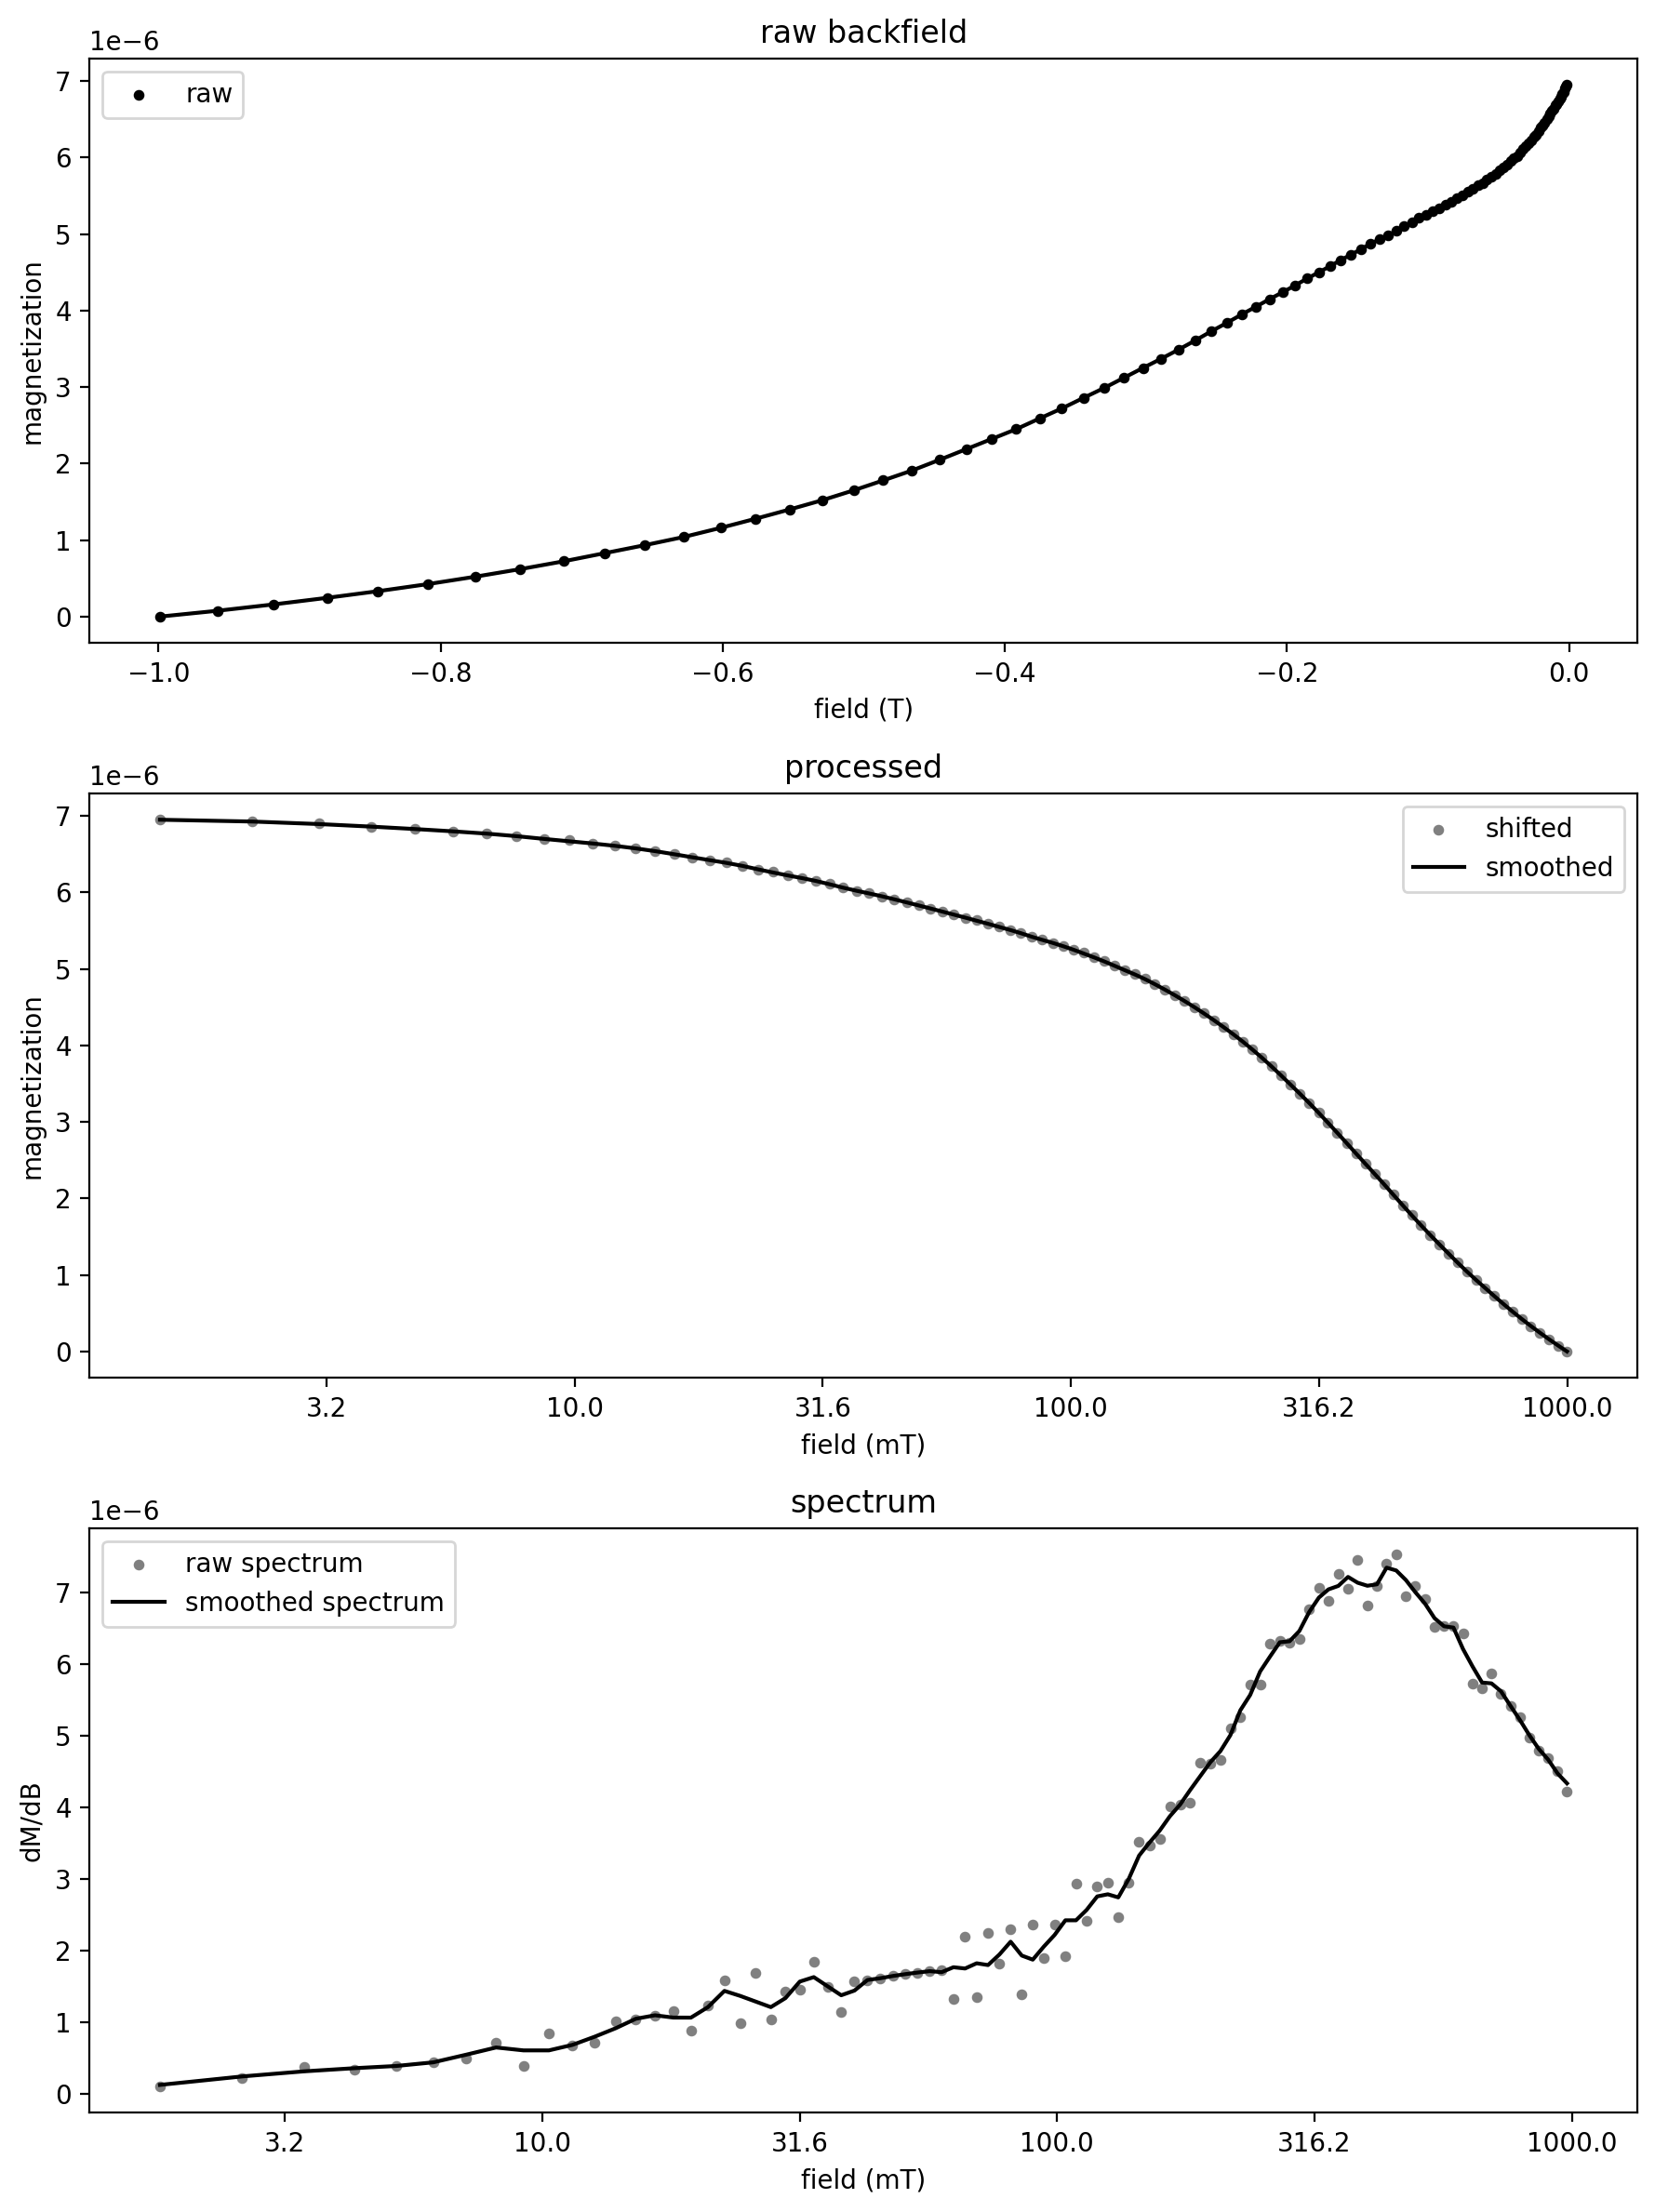

In [11]:
fig, (ax1, ax2, ax3) = rmag.plot_backfield_data(MaxUmnix_experiment, field='B', magnetization='M', figsize=(9, 12), plot_processed=True, plot_spectrum=True, return_figure=True)

### interactive Unmixing demo

#### 1 component

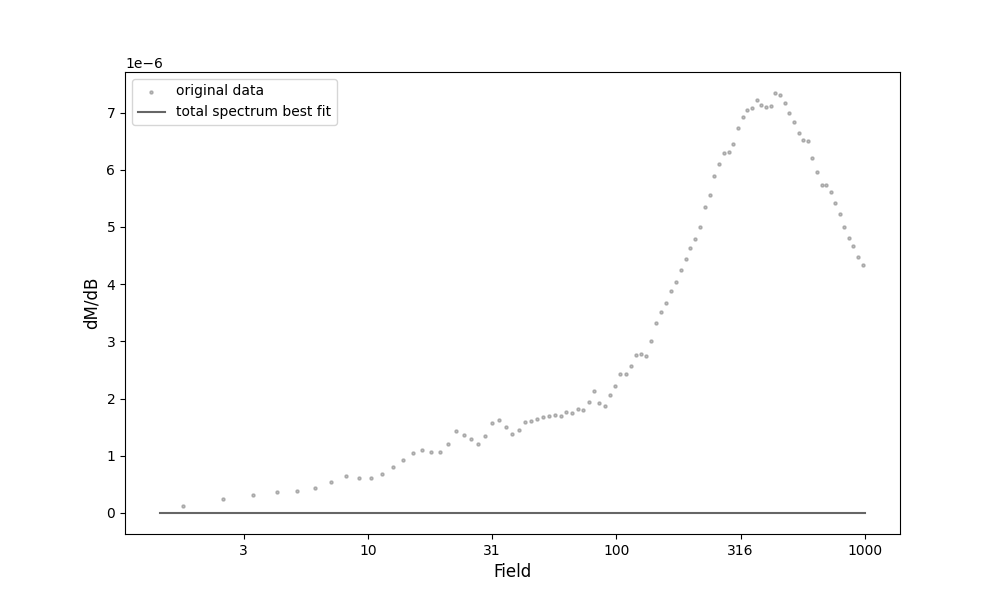

In [ ]:
%matplotlib widget
rmag.interactive_backfield_fit(MaxUmnix_experiment['smoothed_log_dc_field'], 
                          MaxUmnix_experiment['smoothed_magn_mass_shift'], 
                          n_components=1, figsize=(10, 6))

#### 2 components

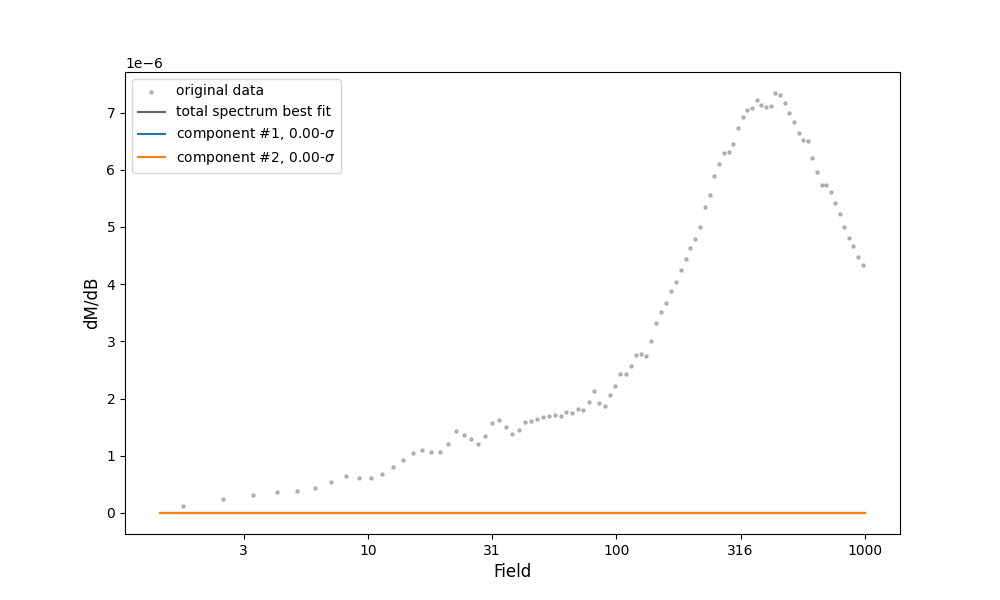

In [26]:
%matplotlib widget
rmag.interactive_backfield_fit(MaxUmnix_experiment['smoothed_log_dc_field'], 
                          MaxUmnix_experiment['smoothed_magn_mass_shift'], 
                          n_components=2, figsize=(10, 6))

In [29]:
# parameters = pd.DataFrame({'amplitude': [1], 'center': [950], 'sigma': [4.6], 'gamma': [-3]})
parameters = pd.DataFrame({'amplitude': [0.6, 0.5], 'center': [250, 100], 'sigma': [3, 5], 'gamma': [0,0]})
# parameters = pd.DataFrame({'amplitude': [0.25, 0.56, 0.74], 'center': [119, 784, 647], 'sigma': [5, 683, 2.5], 'gamma': [-2,1,-1]})
parameters

,amplitude,center,sigma,gamma
0,0.6,250,3,0
1,0.5,100,5,0


### MaxUnmix error estimate

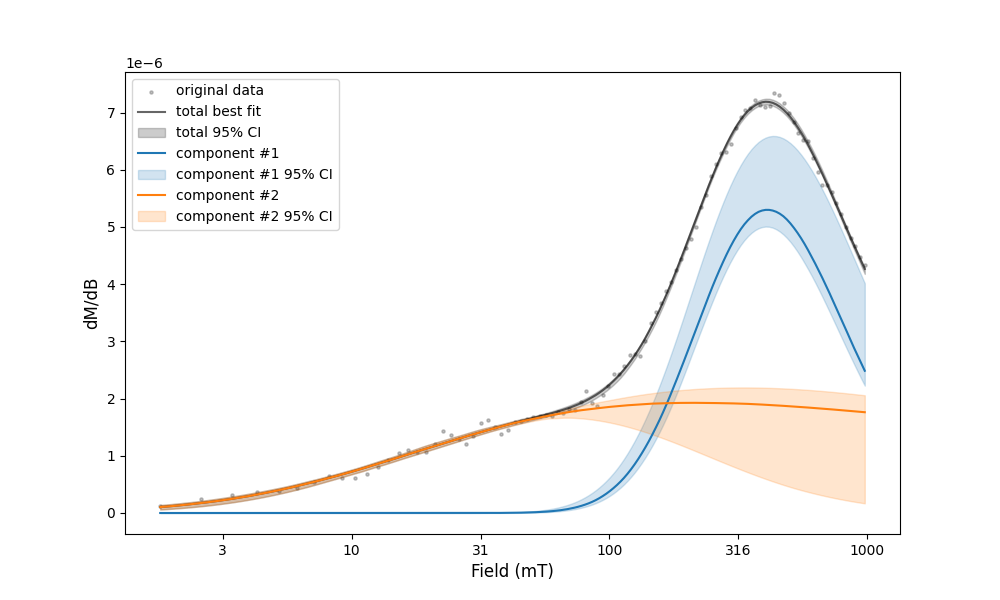

In [30]:
MaxUnmix_ax, MaxUnmix_params = rmag.backfield_MaxUnmix(MaxUmnix_experiment['smoothed_log_dc_field'], 
                                                            MaxUmnix_experiment['smoothed_magn_mass_shift'], 
                                                            n_comps=2, parameters=parameters, n_resample=100)

In [31]:
MaxUnmix_params

{'g1_': {'amplitude': 0.545439083693794,
  'center': 252.86878528113593,
  'sigma': 2.4755997315524882,
  'gamma': 1.3698455210469875,
  'amplitude_std': 0.06198792977364634,
  'center_std': 1.0332607633534268,
  'sigma_std': 1.0701547285554305,
  'gamma_std': 0.17849933687765476},
 'g2_': {'amplitude': 0.9344835320285404,
  'center': 22.882214341054304,
  'sigma': 260.69701392201097,
  'gamma': 3.7377842785790945,
  'amplitude_std': 0.17571864533631779,
  'center_std': 1.7205870074548435,
  'sigma_std': 3.5965584706282585,
  'gamma_std': 1.5419916836271064}}